# week 1

In [1]:
from typing import Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt


## Homogeneous coordinates

In [2]:
def Pi(arr: np.ndarray) -> np.ndarray:
    """
    Also called Pi(x)

    Converts from homogeneous to inhomogeneous coordinates
    """
    return arr[:-1] / arr[-1]


def InvPi(arr: np.ndarray) -> np.ndarray:
    """
    Converts from inhomogeneous to homogeneous coordinates
    """
    return np.vstack((arr, np.ones(arr.shape[1])))


def camera_matrix(
    f: float=1.,
    delta: list[float]=(0,0),
    alpha: float=1.,
    beta: float=0.,
) -> np.ndarray:
    """
    f: focal length
    delta: principal point offset
    alpha: ratio of focal lengths f_y / f_x. Alpha!=1 means non-square pixels
    beta: skew factor with slope = beta / alpha. Beta!=0 means non-orthogonal axes

    Returns the camera matrix
    """
    return np.array([[f,  beta*f, delta[0]],
                     [0, alpha*f, delta[1]],
                     [0,       0,        1]])


def shortest_distance_to_line(ps: np.ndarray, l: np.ndarray) -> float:
    """
    Returns the shortest distance besteen each point in ps to a line l.
    """
    return abs(l.T @ ps) / (abs(ps[-1]) * np.linalg.norm(l[:-1]))

In [3]:
l1 = np.array([[np.sqrt(2)/2, np.sqrt(2)/2, -1]]).T
l2 = np.array([[2, 2, -1]]).T
p1 = np.array([[0, 0, 1]]).T
p2 = np.array([[np.sqrt(2), np.sqrt(2), 1]]).T
p3 = np.array([[np.sqrt(2), np.sqrt(2), 4]]).T

ps = np.concatenate((p1, p2, p3), axis=1)
for l in [l1, l2]:
    print("Distance to line: ", shortest_distance_to_line(ps, l))


Distance to line:  [[1.  1.  0.5]]
Distance to line:  [[0.35355339 1.64644661 0.14644661]]


In [4]:
# 2d coordinates
p1 = np.array([[1, 2, 1]]).T
p2 = np.array([[4, 2, 2]]).T
p3 = np.array([[6, 4, -1]]).T
p4 = np.array([[5, 3, 0.5]]).T

print("Homogeneous to inhomogeneous 2d")
for _p in [p1, p2, p3, p4]:
    print(f"Point: {_p}")
    print(f"Inhomogeneous: {Pi(_p)}")

# 3d coordinates
P1 = np.array([[1, 10, -3, 1]]).T
P2 = np.array([[2, -4, 1.1, 2]]).T
P3 = np.array([[0, 0, -1, 10]]).T
P4 = np.array([[-15, 3, 6, 3]]).T
print("\nHomogeneous to inhomogeneous 3d")

for _p in [P1, P2, P3, P4]:
    print(f"Point: {_p}")
    print(f"Inhomogeneous: {Pi(_p)}")

Homogeneous to inhomogeneous 2d
Point: [[1]
 [2]
 [1]]
Inhomogeneous: [[1.]
 [2.]]
Point: [[4]
 [2]
 [2]]
Inhomogeneous: [[2.]
 [1.]]
Point: [[ 6]
 [ 4]
 [-1]]
Inhomogeneous: [[-6.]
 [-4.]]
Point: [[5. ]
 [3. ]
 [0.5]]
Inhomogeneous: [[10.]
 [ 6.]]

Homogeneous to inhomogeneous 3d
Point: [[ 1]
 [10]
 [-3]
 [ 1]]
Inhomogeneous: [[ 1.]
 [10.]
 [-3.]]
Point: [[ 2. ]
 [-4. ]
 [ 1.1]
 [ 2. ]]
Inhomogeneous: [[ 1.  ]
 [-2.  ]
 [ 0.55]]
Point: [[ 0]
 [ 0]
 [-1]
 [10]]
Inhomogeneous: [[ 0. ]
 [ 0. ]
 [-0.1]]
Point: [[-15]
 [  3]
 [  6]
 [  3]]
Inhomogeneous: [[-5.]
 [ 1.]
 [ 2.]]


In [5]:

def box3d(n: int=16) -> np.ndarray:
    import itertools as it

    points = []
    N = tuple(np.linspace(-1, 1, n))
    
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, ) * n, (j, ) * n, N])))
    
    return np.hstack(points) / 2

def projectpoints(
    K: np.ndarray,
    R: np.ndarray=np.eye(3),
    t: np.ndarray=np.zeros((3, 1)),
    Q: Optional[np.ndarray]=None,
    *,
    radial_dist_factors: Optional[list[float]]=None,
) -> np.ndarray:
    """
    K: Camera matrix
    R: Rotation matrix
    t: Translation vector
    Q: 3D points
    radial_dist_factors: the coefficients of the radial distortion polynomial
        dr(r) = k_3 * r**2 + k_5 * r**4 + k_7 * r**6 + ...
    """

    assert (Q is not None) or (radial_dist_factors is None), "Q must be provided if radial_dist_factors is provided"

    projection_matrix = K @ np.concatenate((R,t), axis=1)

    if Q is None:
        return projection_matrix
    
    if radial_dist_factors is not None:
        # regid transform
        _tmp = Pi(np.concatenate((R,t), axis=1) @ Q)
        
        # radial distortion
        _norm = np.linalg.norm(_tmp, axis=0)
        _scale = 1 + np.stack([c * _norm ** (2*i)
                            for i, c in enumerate(radial_dist_factors, start=1)]).sum(axis=0)
        _tmp = _tmp * _scale
        
        # camera projection
        return K @ InvPi(_tmp)

    return projection_matrix @ Q



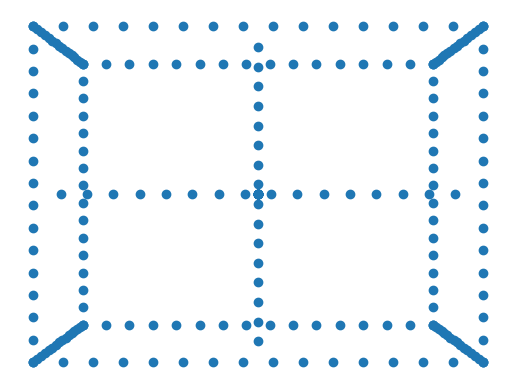

In [6]:
K = np.eye(3)
R = lambda theta: np.array([[np.cos(theta), 0, np.sin(theta)],
                            [0, 1, 0], 
                            [-np.sin(theta), 0, np.cos(theta)]])
t = np.zeros((3, 1))
t[2] = 4
Q = InvPi(box3d())

plt.scatter(*Pi(projectpoints(K, R(0), t, Q)))
plt.axis('off')
plt.show()


### quiz

In [7]:
p = np.array([[2, 4, 3]]).T
l = np.array([[1, 2, 2]]).T
print(shortest_distance_to_line(p, l))


K = camera_matrix(1720, np.array([680, 610]))
R = cv2.Rodrigues(np.array([-0.1, 0.1, -0.2]))[0]
t = np.array([[0.09], [0.05], [0.05]])
Q = InvPi(np.array([[-0.03, 0.01, 0.59]]).T)
Pi(projectpoints(K, R, t, Q))

[[2.38513918]]


array([[1023.50377104],
       [ 930.29756751]])

# Week 2

## distortion

In [8]:
def undistortImage(
    img: np.ndarray,
    radial_dist_factors: np.ndarray,
    K: np.ndarray,
) -> np.ndarray:
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    p = np.stack((x, y, np.ones_like(x))).reshape(3, -1)
    q = np.linalg.inv(K) @ p
    q_d = projectpoints(np.eye(3), Q=InvPi(q), radial_dist_factors=radial_dist_factors)
    p_d = K @ q_d
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    img_undistorted = cv2.remap(img, x_d, y_d, cv2.INTER_LINEAR)
    return img_undistorted

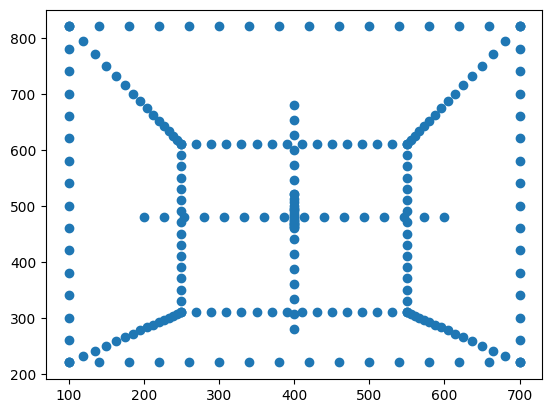

[100. 220.] [700. 820.]


array([[100.],
       [220.]])

In [9]:
K = camera_matrix(
    f=600,
    alpha=1,
    beta=0,
    delta=(400, 400)
)

R = np.eye(3)
t = np.array([[0, .2, 1.5]]).T
Q = InvPi(box3d())

points = Pi(projectpoints(K, R, t, Q))
plt.scatter(*points)
plt.show()

print(points.min(axis=1), points.max(axis=1))

Pi(projectpoints(K, R, t, np.array([[-0.5, -0.5, -0.5, 1]]).T))


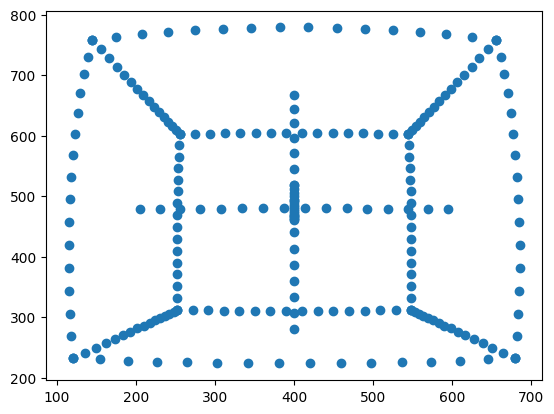

In [10]:
r_coefs = [-0.2]

p_d = Pi(projectpoints(K, R, t, Q, radial_dist_factors=r_coefs))

plt.scatter(*p_d)
plt.show()

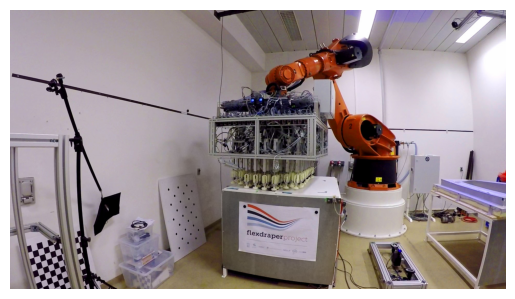

In [11]:
img = cv2.imread('week02/gopro_robot.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
 
plt.imshow(img)
plt.axis('off')
plt.show()

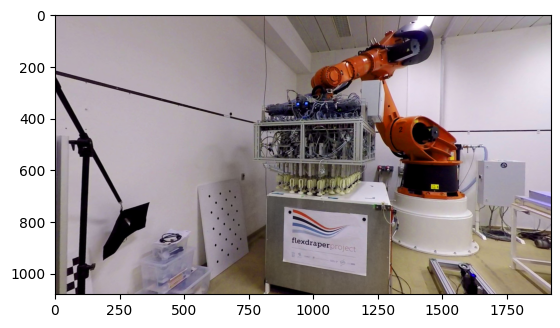

In [12]:
K = camera_matrix(.455732*img.shape[1], (img.shape[1]//2, img.shape[0]//2))
r_coefs = [-0.245031, 0.071524, -0.00994978]
img_undistorted = undistortImage(img, r_coefs, K)
plt.imshow(img_undistorted)
plt.show()

## homography

In [13]:
def normalize2d(ps: np.ndarray) -> np.ndarray:
    """
    Creates a 2D normalization matrix
    where T_inv^-1 @ ps = ps_normalized
    """

    mu = ps.mean(axis=1)
    sigma = ps.std(axis=1)
    T_inv = np.array([[sigma[0], 0, mu[0]],
                  [0, sigma[1], mu[1]],
                  [0, 0, 1]])
    return T_inv


CrossOp = lambda v: np.array([[    0, -v[2],  v[1]],
                              [ v[2],     0, -v[0]],
                              [-v[1],  v[0],     0]])


def hest(
    ps: np.ndarray,
    qs: np.ndarray,
    *,
    normalize: bool=True
) -> np.ndarray:
    """
    Estimates the homography matrix between two sets of points where
    Pi(p) = Pi(H @ q)
    """
    ps = InvPi(ps)
    qs = InvPi(qs)

    if normalize:
        Tp_inv = normalize2d(ps)
        Tp = np.linalg.inv(Tp_inv)

        Tq_inv = normalize2d(qs)
        Tq = np.linalg.inv(Tq_inv)

        ps = Tp @ ps
        qs = Tq @ qs
    
    B = np.vstack([np.kron(q, CrossOp(p)) for p, q in zip(ps.T, qs.T)])
    _, _, V = np.linalg.svd(B)

    H_pred = V[-1].reshape(3, 3).T

    if normalize:
        return Tp_inv @ H_pred @ Tq
    return H_pred


In [14]:
p1 = np.array([[1, 1]]).T
p2 = np.array([[0, 3]]).T
p3 = np.array([[2, 3]]).T
p4 = np.array([[2, 4]]).T

H = np.array([[-2,  0, 1],
              [ 1, -2, 0],
              [ 0,  0, 3]])

points = InvPi(np.concatenate((p1, p2, p3, p4), axis=1))

points2 = H @ points
H_pred = hest(Pi(points), Pi(points2))
points_pred = H_pred @ points2
print(np.array2string(Pi(points_pred), precision=2, suppress_small=True))

[[1. 0. 2. 2.]
 [1. 3. 3. 4.]]


In [15]:
q2 = np.random.randn(2, 100)
q2h = InvPi(q2)
H_true = H
q1h = H_true@q2h
q1 = Pi(q1h)

H_pred = hest(q1, q2, normalize=True)
print(np.array2string(H_true, precision=2, suppress_small=True))
print(np.array2string(H_pred, precision=2, suppress_small=True))

[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]
[[-0.39 -0.    0.19]
 [ 0.19 -0.39 -0.  ]
 [-0.   -0.    0.58]]


# Week 3

## Epipolar geometry

In [16]:
from scipy.spatial.transform import Rotation

def rotation_matrix(*thetas: list[float]) -> np.ndarray:
    """
    Returns a rotation matrix given the angles in the form of
    [theta_x, theta_y, theta_z]
    """
    if len(thetas) == 1:
        thetas = thetas[0]

    return Rotation.from_euler('xyz', thetas).as_matrix()


In [17]:
K = camera_matrix(1000, (300, 200))

R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2 = rotation_matrix(.7, -.5, .8)
t2 = np.array([[.2, 2, 1]]).T

Q = InvPi(np.array([[1, .5, 4]]).T)

q1 = projectpoints(K, R1, t1, Q)
q2 = projectpoints(K, R2, t2, Q)

p1 = projectpoints(np.eye(3), R1, t1, Q)
p2 = projectpoints(np.eye(3), R2, t2, Q)


In [18]:
E = CrossOp(t2[:,0]) @ R2
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)

assert np.isclose(p2.T @ E @ p1, 0), "Essential matrix is wrong"
assert np.isclose(q2.T @ F @ q1, 0), "Fundamental matrix is wrong"


In [19]:
F @ p1

array([[ 7.16724268e-03],
       [ 3.72647737e-04],
       [-4.40344636e+00]])

In [20]:
data = np.load('week03/TwoImageDataCar.npy', allow_pickle=True).item()

# img1 = data['im1']
# R1 = data['R1']
# t1 = data['t1']
# img2 = data['im2']
# R2 = data['R2']
# t2 = data['t2']
# K = data['K']

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(img1)
# ax[1].imshow(img2)
# for a in ax:
#     a.axis('off')
# plt.show()

## Triangulation

In [21]:
def triangulate(qs: list[np.ndarray], Ps: list[np.ndarray]) -> np.ndarray:
    """
    qs: list of 2d points shape (2, n)
    Ps: list of 3x4 projection matrices

    Triangulates points qs from two different views Ps
    """
    qs = [Pi(q) if q.shape[0] == 3 else q for q in qs]

    B = np.vstack([P[2][None, :] * q - P[:-1] for q, P in zip(qs, Ps)])
    _, _, V = np.linalg.svd(B)

    return V[-1][:, None]


In [22]:
Q_pred = triangulate(
    (q1, q2),
    (
        projectpoints(K, R1, t1),
        projectpoints(K, R2, t2)
    )
)

Pi(Q_pred)

array([[1. ],
       [0.5],
       [4. ]])

# Week 4

## Direct linear transform (DLT)

In [23]:
from itertools import product

prettyprint = lambda arr, pres=2: print(np.array2string(arr, precision=pres, suppress_small=True))

In [24]:
Q = np.array(list(product(range(2), repeat=3))).T

_r = np.sqrt(2) / 2
R = np.array([[_r, -_r, 0],
              [_r, _r, 0],
              [0, 0, 1]])

t = np.array([[0, 0, 10]]).T

K = camera_matrix(1000, (1920 // 2, 1080 // 2))

P = projectpoints(K, R, t)

prettyprint(q := Pi(P @ InvPi(Q)))

[[ 960.    960.    889.29  895.72 1030.71 1024.28  960.    960.  ]
 [ 540.    540.    610.71  604.28  610.71  604.28  681.42  668.56]]


In [25]:
def pest(
    qs: np.ndarray,
    Qs: np.ndarray
) -> np.ndarray:
    """
    Estimates the projection matrix between two sets of points where
    Pi(P) = Pi(H @ Q)
    """
    qs = InvPi(qs)
    Qs = InvPi(Qs)
    
    B = np.vstack([np.kron(Q, CrossOp(q)) for q, Q in zip(qs.T, Qs.T)])
    _, _, V = np.linalg.svd(B)

    P_pred = V[-1].reshape(4, 3).T
    P_pred /= P_pred[2,2] # normalize

    return P_pred

P_pred = pest(q, Q)
q_est = Pi(P_pred @ InvPi(Q))
np.sqrt(np.square(np.linalg.norm(q - q_est, axis=0)).mean())

2.3292087342443577e-10

# Checkeroard calibration Zhang

In [26]:
def checkerboard_points(
    n: int=8,
    m: int=8,
    *,
    only_corners: bool=False
) -> np.ndarray:
    """
    Returns the 3D coordinates of a checkerboard
    """
    if only_corners:
        p = np.array(list(product([0, n-1], [0, m-1], [0.]))).T
    else:
        p = np.array(list(product(range(n), range(m), [0.]))).T

    bias = np.array([[(n-1)/2, (m-1)/2, 0]]).T
    return p - bias

Q_omega = checkerboard_points(10, 20)

R_a = rotation_matrix(np.pi/10, 0, 0)
R_b = rotation_matrix(0, 0, 0)
R_c = rotation_matrix(-np.pi/10, 0, 0)

Q_a = R_a @ Q_omega
Q_b = R_b @ Q_omega
Q_c = R_c @ Q_omega

# 3d scatter
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(*Q_a, label='A')
# ax.scatter(*Q_b, label='B')
# ax.scatter(*Q_c, label='C')
# ax.legend()
# plt.show()

q_a = Pi(P @ InvPi(Q_a))
q_b = Pi(P @ InvPi(Q_b))
q_c = Pi(P @ InvPi(Q_c))


In [27]:
def estimateHomographies(Q_omega: np.ndarray, qs: list[np.ndarray]) -> list[np.ndarray]:
    """
    Estimates the homographies between the 3D points and the 2D points.

    Q_omega: 3D points
    qs: 2D points
    """
    Q_omega_bar = Q_omega[:2]
    return [hest(q, Q_omega_bar) for q in qs]


def estimate_b(Hs: list[np.ndarray]) -> np.ndarray:
    """
    Estimates the vector b which is used for the estimation of the intrinsics
    """
    # b_true = np.array([B_true[0,0], B_true[0,1], B_true[1,1], B_true[0,2], B_true[1,2], B_true[2,2]])

    V = list()
    for H in Hs:

        v = lambda a, b: np.array([
            H[0,a]*H[0,b],
            H[0,a]*H[1,b] + H[1,a]*H[0,b],
            H[1,a]*H[1,b],
            H[2,a]*H[0,b] + H[0,a]*H[2,b],
            H[2,a]*H[1,b] + H[1,a]*H[2,b],
            H[2,a]*H[2,b]])

        # print(v(0, 0) @ b_true - H[:, 0].T @ B_true @ H[:, 0])

        v1 = v(0, 1)
        v2 = v(0, 0) - v(1, 1)        

        V.extend((v1, v2))
    V = np.stack(V)

    return np.linalg.svd(V)[-1][-1]


def estimateIntrinsics(Hs: list[np.ndarray]) -> np.ndarray:
    """
    Estimates the camera matrix K, from the homographies
    """
    b = estimate_b(Hs)

    B = np.array([[b[0], b[1], b[3]],
                  [b[1], b[2], b[4]],
                  [b[3], b[4], b[5]]])
    
    v0 = (B[0,1]*B[0,2] - B[0,0]*B[1,2]) / (B[0,0]*B[1,1] - B[0,1]**2)
    lam = B[2,2] - (B[0,2]**2 + v0 * (B[0,1]*B[0,2] - B[0,0]*B[1,2])) / B[0,0]
    alpha = np.sqrt(lam / B[0,0])
    beta = np.sqrt(lam * B[0,0] / (B[0,0]*B[1,1] - B[0,1]**2))
    gamma = -B[0,1] * alpha**2 * beta / lam
    u0 = gamma * v0 / beta - B[0,2] * alpha**2 / lam

    K = np.array([[alpha, gamma, u0],
                  [    0,  beta, v0],
                  [    0,     0,  1]])

    return K


def estimateExtrinsics(K: np.ndarray, Hs: list[np.ndarray]) -> tuple[list[np.ndarray], list[np.ndarray]]:
    """
    Estimates the extrinsics given the camera matrix and the homographies

    K: Camera matrix
    Hs: Homographies

    Returns the rotation matrices and the translation vectors
    """
    Rs = list()
    ts = list()

    K_inv = np.linalg.inv(K)

    for H in Hs:
        t = K_inv @ H[:, 2]

        if t[2] < 0:
            t = -t
            H = -H

        r1 = K_inv @ H[:, 0][:, None]
        r2 = K_inv @ H[:, 1][:, None]

        r1 /= np.linalg.norm(r1, axis=0)
        r2 /= np.linalg.norm(r2, axis=0)
        r3 = np.cross(
            r1.squeeze(),
            r2.squeeze())[:, None]

        R = np.concatenate((r1, r2, r3), axis=1)
        Rs.append(R)
        ts.append(t[:, None])

    return Rs, ts


def calibratecamera(
    qs: list[np.ndarray],
    Q: np.ndarray,
    *,
    verbose: bool=False
) -> tuple[np.ndarray, list[np.ndarray], list[np.ndarray]]:
    """
    qs: list of 2d points
    Qs: 3d points
    """
    Hs = estimateHomographies(Q, qs)
    K = estimateIntrinsics(Hs)
    Rs, ts = estimateExtrinsics(K, Hs)

    if verbose:
        err = 0
        for R, t, q_true in zip(Rs, ts, qs):
            q_est = Pi(projectpoints(K, R, t, InvPi(Q)))
            _err = np.linalg.norm(q_true - q_est, axis=0) ** 2
            err += _err.mean()

            # plt.scatter(*q_true, label='True')
            # plt.scatter(*q_est, label='Est')
            # plt.legend()
            # plt.show()

        print(f'Reprojection error: {err:.4}')

    return K, Rs, ts

In [28]:
Ke_est, Rs, ts = calibratecamera((q_a, q_b, q_c), Q_omega, verbose=True)


Reprojection error: 2.586e+08


In [29]:
K_est, Rs, ts = calibratecamera([q + np.random.randn(2,1) for q in (q_a, q_b, q_c)], Q_omega)

prettyprint(K - K_est)

[[ 1.92  0.    0.65]
 [ 0.    2.16 -0.33]
 [ 0.    0.    0.  ]]


# Week 5

In [30]:
R1 = np.eye(3)
R2 = np.eye(3)
t1 = np.array([[0, 0, 1]]).T
t2 = np.array([[0, 0, 20]]).T
K1 = K2 = camera_matrix(700, (600, 400))

Q = np.array([[1, 1, 0]]).T


In [31]:
P1 = projectpoints(K1, R1, t1)
P2 = projectpoints(K2, R2, t2)
q1 = Pi(P1 @ InvPi(Q))
q2 = Pi(P2 @ InvPi(Q))

q1_tilde = q1 + np.array([[1, -1]]).T
q2_tilde = q2 + np.array([[1, -1]]).T


In [32]:
Q_tilde = Pi(triangulate((q1_tilde, q2_tilde), (P1, P2)))
reprojection_err = np.sqrt(
    np.linalg.norm(q1_tilde - Pi(P1 @ InvPi(Q_tilde))) ** 2 + 
    np.linalg.norm(q2_tilde - Pi(P2 @ InvPi(Q_tilde))) ** 2
)
reprojection_err


13.449805855171643

In [33]:
def triangulate_nonlin(
    qs: list[np.ndarray],
    Ps: list[np.ndarray],
) -> np.ndarray:
    """
    Non-linear triangulation
    """
    import scipy.optimize

    def compute_residuals(Q):
        Q = Q[:, None]
        return np.concatenate(
            [Pi(P @ InvPi(Q)) - q
             for q, P in zip(qs, Ps)],
            axis=0
        ).mean(axis=1)
    
    x0 = Pi(triangulate(qs, Ps))[:,0]
    x = scipy.optimize.least_squares(compute_residuals, x0)
    return x.x[:, None]

Q_tilde_nonlin = triangulate_nonlin((q1_tilde, q2_tilde), (P1, P2))

reprojection_err = np.sqrt(
    np.linalg.norm(q1_tilde - Pi(P1 @ InvPi(Q_tilde_nonlin))) ** 2 + 
    np.linalg.norm(q2_tilde - Pi(P2 @ InvPi(Q_tilde_nonlin))) ** 2
)
reprojection_err


1.3418251459026311

# Week 6

In [34]:
def gaussian1DKernel(
    sigma: float,
    length: float=5,
    num: Optional[int]=None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns a 1D gaussian kernel and its derivative

    sigma: standard deviation
    length: how many standard deviations to consider
    num: number of samples
    """
    _s = sigma * length
    num = num or 2 * int(_s) + 1

    x = np.linspace(-_s, _s, num)
    g = np.exp(-x**2 / (2 * sigma**2))
    g /= g.sum()

    gd = -x / sigma**2 * g
    return g, gd


def gaussianSmoothing(
    im: np.ndarray,
    sigma: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Smooths an image with a gaussian kernel, and returns the smoothed image and its derivatives

    im: image
    sigma: standard deviation
    """
    g, gd = gaussian1DKernel(sigma)

    im = cv2.sepFilter2D(im, -1, g, g)
    Ix = cv2.sepFilter2D(im, -1, gd, g)
    Iy = cv2.sepFilter2D(im, -1, g, gd)

    return im, Ix, Iy


def structureTensor(
    im: np.ndarray,
    sigma: float,
    epsilon: float
) -> np.ndarray:
    """
    Computes the structure tensor of an image

    im: image
    sigma: standard deviation for the gaussian smoothing
    epsilon: stadard deviation f
    """
    _, Ix, Iy = gaussianSmoothing(im, sigma)

    g_eps, _ = gaussian1DKernel(epsilon)

    a = cv2.sepFilter2D(Ix**2, -1, g_eps, g_eps)
    b = cv2.sepFilter2D(Iy**2, -1, g_eps, g_eps)
    c = cv2.sepFilter2D(Ix*Iy, -1, g_eps, g_eps)

    return a, b, c


def harrisMeasure(
    im: np.ndarray,
    sigma: float,
    epsilon: float,
    k: float=0.06
) -> np.ndarray:
    """
    Computes the Harris measure of an image
    """

    a, b, c = structureTensor(im, sigma, epsilon)

    det = a * b - c ** 2
    tr = a + b
    return det - k * tr ** 2


def cornerDetector(
    im: np.ndarray,
    sigma: float,
    epsilon: float,
    tau: float,
    k: float = 0.06,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Detects corners in an image

    Coordinates might be transposed
    """
    r = harrisMeasure(im, sigma, epsilon, k)

    _range = 0.1 * r.max(), 0.8 * r.max()
    if tau < _range[0] or tau > _range[1]:
        print(f"{tau=} should be in the range {_range}")

    c = (
        (r[1:-1, 1:-1] > tau) &
        (r[1:-1, 1:-1] > r[2:, 1:-1]) &
        (r[1:-1, 1:-1] > r[:-2, 1:-1]) &
        (r[1:-1, 1:-1] > r[1:-1, 2:]) &
        (r[1:-1, 1:-1] > r[1:-1, :-2])
    )
    c = np.pad(c, ((1, 1), (1, 1)))
    return np.where(c) 


tau=5e-06 should be in the range (2.0036305068060758e-05, 0.00016029044054448606)


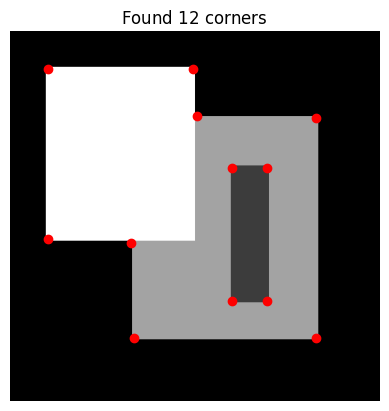

In [35]:
img = cv2.imread('week06/data/TestIm1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255

c = cornerDetector(img, 1, 1, 0.000005)

plt.imshow(img, cmap='gray')
plt.title(f'Found ${len(c[0])}$ corners')
plt.scatter(*c[::-1], c='r')
plt.axis('off')
plt.show()

## Canny edge

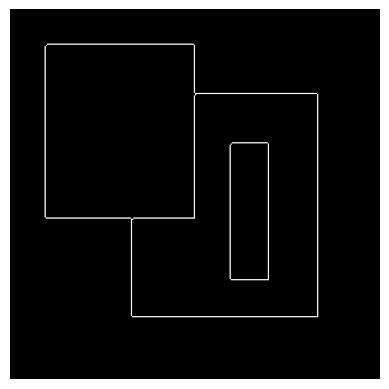

In [36]:
img = cv2.imread('week06/data/TestIm1.png')

edges = cv2.Canny(img, 100, 200)

plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()


# Week 7

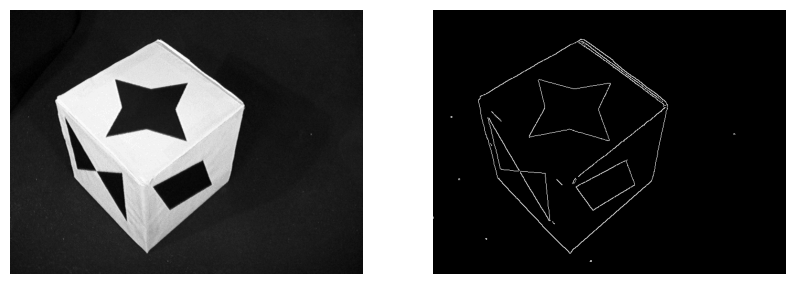

In [37]:
img = cv2.imread('week06/data/Box3.bmp')
edges = cv2.Canny(img, 100, 200)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(edges, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()

In [38]:
import skimage.transform

hspace, angles, dists = skimage.transform.hough_line(edges)
extH, extAngles, extDists = skimage.transform.hough_line_peaks(hspace, angles, dists, num_peaks=6)

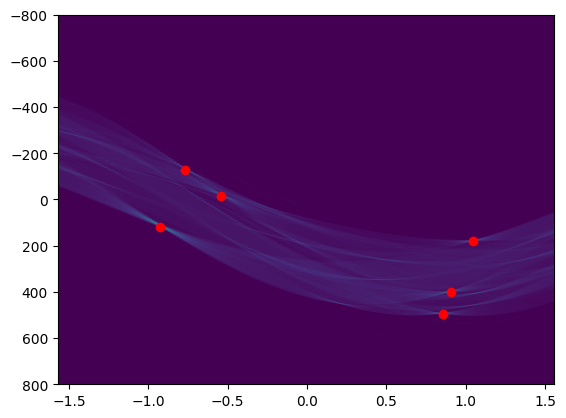

In [39]:
extent = [angles[0], angles[-1], dists[-1], dists[0]]

plt.imshow(hspace, extent=extent, aspect='auto')
plt.scatter(extAngles, extDists, c='r')
plt.show()

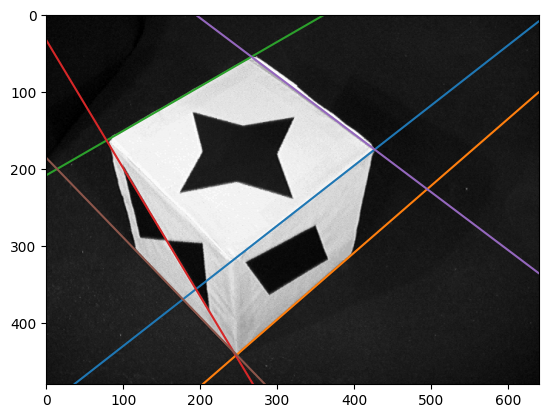

In [40]:
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

plt.imshow(img, cmap='gray')
for angle, dist in zip(extAngles, extDists):
    l = np.array([np.cos(angle), np.sin(angle), -dist])
    DrawLine(l, img.shape)

## RANSAC

In [41]:
def test_points(n_in, n_out):
    """
    Samples random points with n_in is the number of inliners and n_out is the number of outliers
    """
    a = (np.random.rand(n_in) - .5) * 10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T


def fit_line(q1, q2):
    """
    The line is parameterized as l = [a, b, c] where a*x + b*y + c = 0
    """
    a = np.cross(q1, q2)
    return a / np.linalg.norm(a[:2])


def pca_line(x): # assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return np.array(l)


def distance_to_line(l, q):
    """
    Returns the distance between a line and a point

    The points are homogeneous 2D coordinates
    """
    l /= np.linalg.norm(l[:2])
    return abs(l.T @ q) / np.linalg.norm(l[:2])


def ransac_line(points, threshold=0.1, max_iters=1000, p=0.99):
    num_points = points.shape[1]

    sample = lambda: np.random.choice(num_points, 2, replace=False)

    best_inliers = 0
    best_line = None

    for i in range(1, max_iters+1):
        q1, q2 = points[:, sample()].T
        line = fit_line(q1, q2)
        inliers = distance_to_line(line, points) < threshold

        if inliers.sum() > best_inliers:
            best_inliers = inliers.sum()
            best_line = line
        
        eps_hat = 1 - best_inliers / num_points

        if np.log(1 - p) / np.log(1 - (1 - eps_hat)**i) < i:
            print(i)
            break

    inliers = distance_to_line(best_line, points) < threshold
    line = pca_line(Pi(points[:, inliers]))

    return line

28


/tmp/ipykernel_570373/880725517.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  if np.log(1 - p) / np.log(1 - (1 - eps_hat)**i) < i:


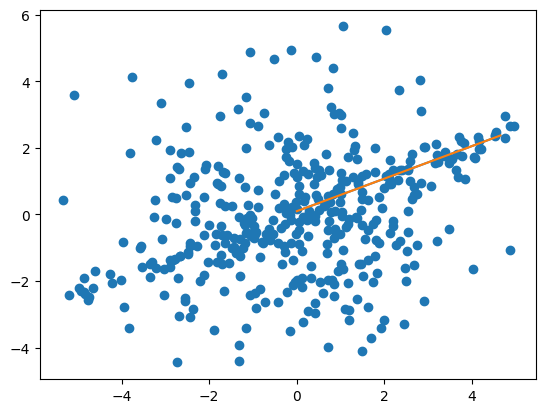

In [53]:
points = InvPi(test_points(100, 300))
line = ransac_line(points, threshold=0.25)

plt.scatter(*Pi(points))
DrawLine(line, points.max(axis=1))
DrawLine(line, points.max(axis=1))

# Week 8

# Week 9

# Week 10

# Week 11

# Week 12